In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from model import MLP
from dataloaders import DemoDataset
from utils import read_json

train on `recording_0002_2020_12_3.h5` with position and euler vector as features (no force), contacting phase extracted

In [2]:
# setup dataloader instances
cfg = read_json("config.json")
dataset_cfg = cfg["dataset"]
dataloader_cfg = cfg["dataloader"]
test_cfg = cfg["test"]
# dataset_cfg["params"]["fnames"] = ["recording_0002_2020_12_3.h5"]
dataset_cfg["params"]["fnames"] = ["recording_0003_2020_12_3.h5"]

dataset = DemoDataset(**dataset_cfg["params"])

dataset start time 5.794544458389282, end time 13.002792596817017
there are 721 samples


In [3]:
# build model architecture, then print to console
model = MLP(input_dims=12, output_dims=6)
# get function handles of loss and metrics
criterion = torch.nn.MSELoss()
metrics = []

ckpt = torch.load("saved_02/ckpts/ckpt-epoch95.pth")
model.load_state_dict(ckpt["state_dict"])

# device = torch.device('cuda')
model = model.to('cuda')
model.eval()

loss_ls = []
pred_pos = []

In [4]:
with torch.no_grad():
    for i in tqdm(range(len(dataset))):
        state_action, target = dataset.__getitem__(i)
        state_action = torch.tensor(state_action).to('cuda')
        target = torch.tensor(target).to('cuda')

        output = model(state_action)

        loss = criterion(output, target)

        pred_pos.append(output.cpu().numpy()[:3])
        loss_ls.append(loss.item())

100%|██████████| 721/721 [00:00<00:00, 2136.76it/s]


In [5]:
# # normalize loss
# loss_ls = loss_ls / np.amax(loss_ls)

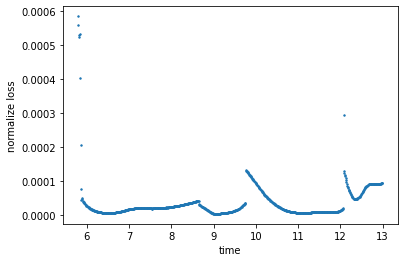

In [6]:
plt.scatter(dataset.sample_time, loss_ls, s=2)
plt.xlabel("time")
plt.ylabel("normalize loss")
plt.show()

Visualization of trajectories (contact phase only)

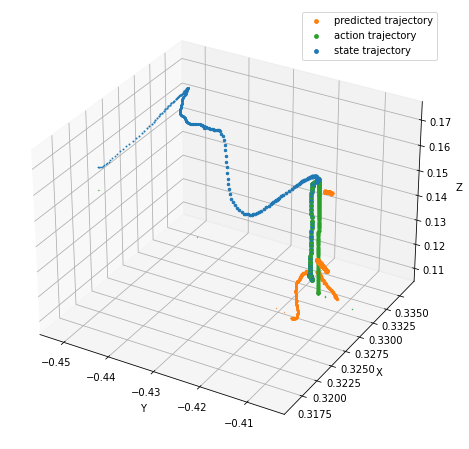

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

pred_pos = np.array(pred_pos)
state_pos = dataset.paired_states_actions[:, 0, :3]
action_pos = dataset.paired_states_actions[:, 1, :3]

for t in range(0, len(dataset.sample_time) - 1, 2):
    size = t/50
    ax.scatter(pred_pos[t,1], pred_pos[t,0], pred_pos[t,2], s=size, c='tab:orange')
    ax.scatter(action_pos[t,1], action_pos[t,0], action_pos[t,2], s=size, c='tab:green')
    ax.scatter(state_pos[t,1], state_pos[t,0], state_pos[t,2],s=size, c='tab:blue')

ax.scatter(pred_pos[-1,1], pred_pos[-1,0], pred_pos[-1,2], label='predicted trajectory', s=size, c='tab:orange')
ax.scatter(action_pos[-1,1], action_pos[-1,0], action_pos[-1,2], label='action trajectory', s=size, c='tab:green')
ax.scatter(state_pos[-1,1], state_pos[-1,0], state_pos[-1,2], label='state trajectory', s=size, c='tab:blue')

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.legend()
plt.show()

Rollout evaluation

In [8]:
roll_out_loss = []
roll_out_pos = []

state_action = None
target = None
rollout_pred = None

with torch.no_grad():
    # first rollout input state is ground truth
    state_action, target = dataset.__getitem__(0)
    rollout_pred = state_action[:6]

    for i in tqdm(range(len(dataset))):
        state_action, target = dataset.__getitem__(i)

        # substitute the input state with last predicted output
        state_action[:6] = rollout_pred
        state_action = torch.tensor(state_action).to('cuda')

        # same target
        target = torch.tensor(target).to('cuda')

        output = model(state_action)
        loss = criterion(output, target)

        rollout_pred = output.cpu().numpy()

        roll_out_pos.append(rollout_pred[:3])
        roll_out_loss.append(loss.item())

100%|██████████| 721/721 [00:00<00:00, 2011.97it/s]


In [9]:
# normalize loss
# roll_out_loss = roll_out_loss / np.amax(roll_out_loss)

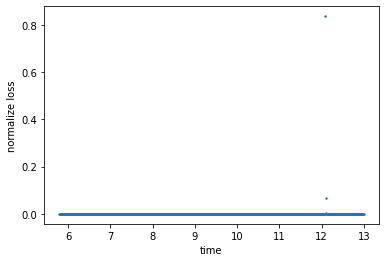

In [10]:
plt.scatter(dataset.sample_time, roll_out_loss, s=2)
plt.xlabel("time")
plt.ylabel("normalize loss")
plt.show()

first 600 data points without 

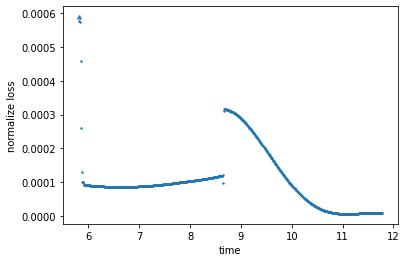

In [11]:
plt.scatter(dataset.sample_time[:600], roll_out_loss[:600], s=2)
plt.xlabel("time")
plt.ylabel("normalize loss")
plt.show()

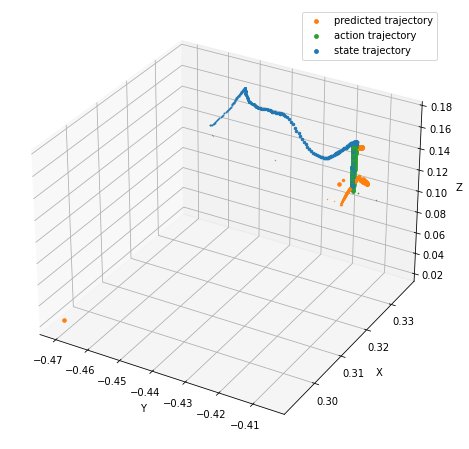

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

roll_out_pos = np.array(roll_out_pos)

for t in range(0, len(dataset.sample_time) - 1, 2):
    size = t/50
    ax.scatter(roll_out_pos[t,1], roll_out_pos[t,0], roll_out_pos[t,2], s=size, c='tab:orange')
    ax.scatter(action_pos[t,1], action_pos[t,0], action_pos[t,2], s=size, c='tab:green')
    ax.scatter(state_pos[t,1], state_pos[t,0], state_pos[t,2],s=size, c='tab:blue')

ax.scatter(roll_out_pos[-1,1], roll_out_pos[-1,0], roll_out_pos[-1,2], label='predicted trajectory', s=size, c='tab:orange')
ax.scatter(action_pos[-1,1], action_pos[-1,0], action_pos[-1,2], label='action trajectory', s=size, c='tab:green')
ax.scatter(state_pos[-1,1], state_pos[-1,0], state_pos[-1,2], label='state trajectory', s=size, c='tab:blue')

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.legend()


plt.show()

set limit to zoom in

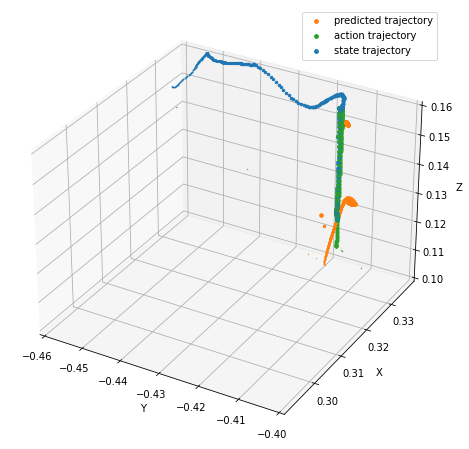

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

roll_out_pos = np.array(roll_out_pos)

for t in range(0, len(dataset.sample_time) - 1, 2):
    size = t/50
    ax.scatter(roll_out_pos[t,1], roll_out_pos[t,0], roll_out_pos[t,2], s=size, c='tab:orange')
    ax.scatter(action_pos[t,1], action_pos[t,0], action_pos[t,2], s=size, c='tab:green')
    ax.scatter(state_pos[t,1], state_pos[t,0], state_pos[t,2],s=size, c='tab:blue')

ax.scatter(roll_out_pos[-1,1], roll_out_pos[-1,0], roll_out_pos[-1,2], label='predicted trajectory', s=size, c='tab:orange')
ax.scatter(action_pos[-1,1], action_pos[-1,0], action_pos[-1,2], label='action trajectory', s=size, c='tab:green')
ax.scatter(state_pos[-1,1], state_pos[-1,0], state_pos[-1,2], label='state trajectory', s=size, c='tab:blue')

# set limit to zoom in
ax.set_xlim([-.46, -.4])
ax.set_zlim([.1, .16])

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.legend()


plt.show()

visualize only the outliers

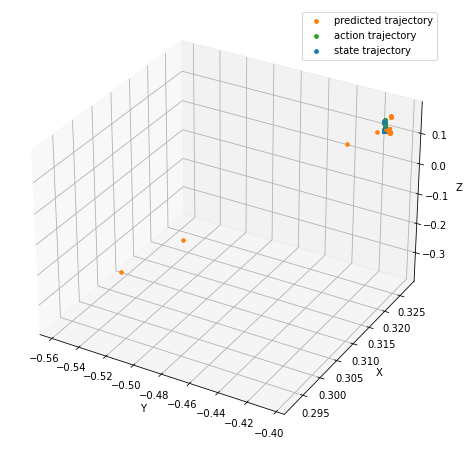

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# check the last 100 data points
for t in range(len(dataset.sample_time) - 100, len(dataset.sample_time) - 1):
    size = t/50
    ax.scatter(roll_out_pos[t,1], roll_out_pos[t,0], roll_out_pos[t,2], s=size, c='tab:orange')
    ax.scatter(action_pos[t,1], action_pos[t,0], action_pos[t,2], s=size, c='tab:green')
    ax.scatter(state_pos[t,1], state_pos[t,0], state_pos[t,2],s=size, c='tab:blue')

ax.scatter(roll_out_pos[-1,1], roll_out_pos[-1,0], roll_out_pos[-1,2], label='predicted trajectory', s=size, c='tab:orange')
ax.scatter(action_pos[-1,1], action_pos[-1,0], action_pos[-1,2], label='action trajectory', s=size, c='tab:green')
ax.scatter(state_pos[-1,1], state_pos[-1,0], state_pos[-1,2], label='state trajectory', s=size, c='tab:blue')

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.legend()


plt.show()